In [ ]:
%matplotlib inline


In [2]:
import torch
torch.cuda.empty_cache()
import pandas as pd

In [15]:
#import splitfolders
#splitfolders.ratio("Data", output="Data1", seed=1337, ratio=(.6, .3,.1), group_prefix=None)

In [3]:
from __future__ import print_function, division
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torchsummary import summary
import pandas as pd
from tqdm import tqdm
plt.ion()  


In [1]:
import os
import random
import shutil

# Path to the original dataset directory
dataset_dir = 'D:/Prateek/2.5K'

# Define the directory names for train, validation, and test sets
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Create the train, validation, and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of gesture folders
gesture_folders = sorted(os.listdir(dataset_dir))

# Define the train, validation, and test ratios (e.g., 70%, 15%, 15%)
train_ratio = 0.7
val_ratio = 0.20
test_ratio = 0.10

# Iterate over the gesture folders
for folder_name in gesture_folders:
    folder_path = os.path.join(dataset_dir, folder_name)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)  # Randomly shuffle the image files
    
    # Calculate the number of images for each set based on the ratios
    num_images = len(image_files)
    num_train = int(train_ratio * num_images)
    num_val = int(val_ratio * num_images)
    num_test = num_images - num_train - num_val
    
    # Split the image files into train, validation, and test sets
    train_files = image_files[:num_train]
    val_files = image_files[num_train:num_train+num_val]
    test_files = image_files[num_train+num_val:]
    
    # Move the image files to their respective directories
    for file in train_files:
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(train_dir, folder_name, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)
    
    for file in val_files:
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(val_dir, folder_name, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)
    
    for file in test_files:
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(test_dir, folder_name, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)


In [4]:
batch_size=15
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
       
       
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        
        
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        
      
        
        
        transforms.ToTensor(),
       
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
        
    ]),
    'test': transforms.Compose([
        
         transforms.Resize(256),
        transforms.CenterCrop(224),
       
        transforms.ToTensor(),
        
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

data_dir = 'D:/Prateek/2.5K'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=15,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


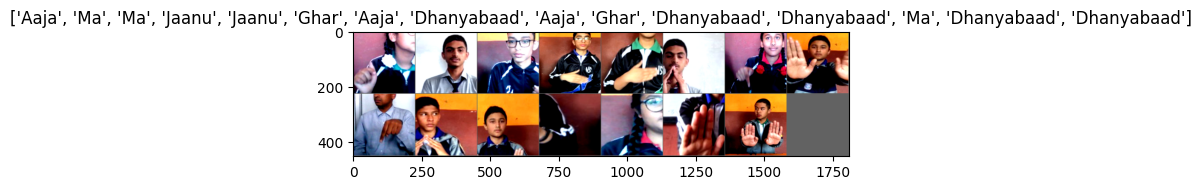

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.3854, 0.3854, 0.3854])
    std = np.array([0.4140, 0.4140, 0.4140])
    inp = std * inp + mean
    
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
tloss=[]
vloss=[]
tacc=[]
vacc=[]

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                tloss.append(epoch_loss)
                tacc.append(epoch_acc)
            if phase == 'val':
                vloss.append(epoch_loss)
                vacc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [7]:
model_ft = models.vgg16(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.classifier[6] = nn.Linear(model_ft.classifier[6].in_features
, 5)

model_ft.classifier.add_module("7", nn.LogSoftmax(dim = 1))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\LENOVO\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
num_epochs=5
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/4
----------


KeyboardInterrupt: 

In [9]:
tacc=[tensor.tolist() for tensor in tacc]
vacc=[tensor.tolist() for tensor in vacc]

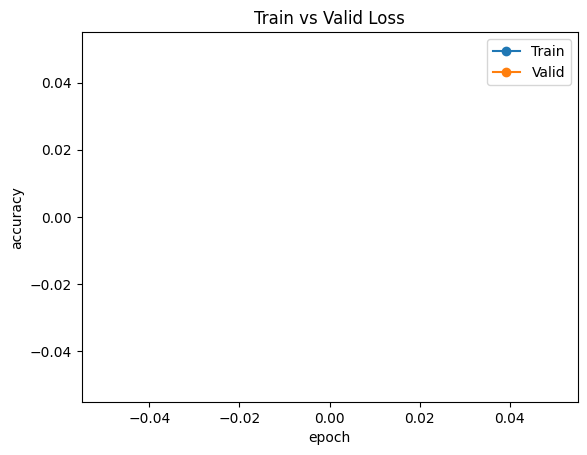

In [10]:
plt.plot(tacc,'-o')
plt.plot(vacc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

plt.show()

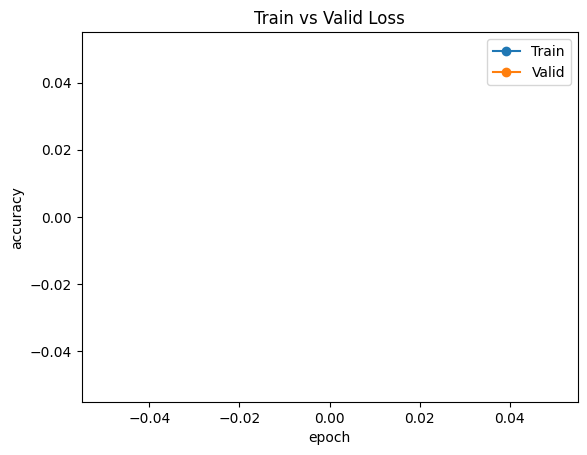

In [11]:
plt.plot(tloss,'-o')
plt.plot(vloss,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

plt.show()

In [12]:
since = time.time()
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


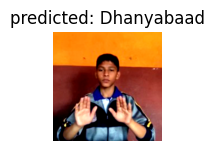

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


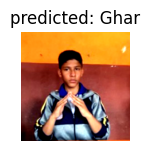

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


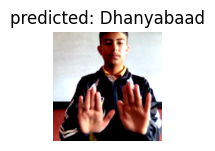

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


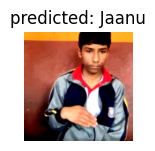

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


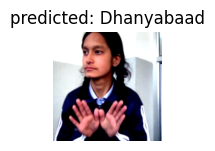

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


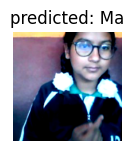

In [13]:
visualize_model(model_ft)

In [14]:
torch.save(model_ft,"e3.pth")

In [15]:
import time

since = time.time()
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=8, shuffle=True, num_workers=3)
correct_count, all_count = 0, 0

for images, labels in testloader:
    images = images.to(device)  # Move images to GPU
    labels = labels.to(device)  # Move labels to GPU
    
    for i in range(len(labels)):
        img = images[i].view(1, 3, 224, 224)
        
        with torch.no_grad():
            logps = model_ft(img)
        
        ps = torch.exp(logps)
        probab = list(ps[0].cpu())
        pred_label = probab.index(max(probab))
        true_label = labels[i]
        
        if true_label == pred_label:
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count / all_count))

time_elapsed = time.time() - since
print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


KeyboardInterrupt: 

In [16]:
nb_classes = 5

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

KeyboardInterrupt: 

In [ ]:
nb_classes = 3
class_names = ['Dhanyabaad', 'Ghar', 'Khana']

confusion_matrix = np.zeros((nb_classes, nb_classes))

# Rest of your code

plt.figure(figsize=(15, 10))

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')